In [1]:
import pandas as pd
import numpy as np
from numpy import sin, cos, arccos, pi, round
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from IPython.display import clear_output
from tqdm import tqdm
import warnings

import lightgbm as lgb

from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, precision_recall_curve, roc_curve, auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import Lasso, LinearRegression, HuberRegressor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
def classifier_performance(Y, Y_hat, Y_score):
    fpr, tpr, thresholds_roc = roc_curve(Y, Y_score)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 10})

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.grid(True)
    plt.show()
    
    
    precision = precision_score(Y, Y_hat)
    recall = recall_score(Y, Y_hat)
    f1 = f1_score(Y, Y_hat)
    print(f"Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F1 score: {round(f1, 4)}, Accuracy: {round(np.sum(Y == Y_hat) / Y.shape[0], 4)}")

In [3]:
def standardizer(X_train, X_test):
    """
    features need to be standardize:
    Total Land Transfer Area, Total Building Transfer Area, Current Building Layout-Rooms, Current Building Layout-Living Rooms,
    Current Building Layout-Bathrooms, Total Parking Space Area, Total Parking Price, Main Building Area, Auxiliary Building Area,
    Balcony Area, Latitude, Longitude, Total Floors, Sale Floor, 'Age', Building land ratio, Main Building Percentage
    """
    features = ['Total Land Transfer Area', 'Total Building Transfer Area', 'Current Building Layout-Rooms', 'Current Building Layout-Living Rooms',
    'Current Building Layout-Bathrooms', 'Total Parking Space Area', 'Total Parking Price', 'Main Building Area', 'Auxiliary Building Area',
    'Balcony Area', 'Latitude', 'Longitude', 'Total Floors', 'Sale Floor', 'Age', 'Building land ratio', 'Main building percentage']
    X_c_train = X_train.copy()
    X_c_test = X_test.copy()

    for f in features:
        mean = X_c_train[f].mean()
        std = X_c_train[f].std()
        X_c_train[f] = (X_c_train[f] - mean)/ std
        X_c_test[f] = (X_c_test[f] - mean)/ std
        
    return X_c_train, X_c_test

In [4]:
def calDistrictCenter(distict_bool_data, longitude, latitude):
    index = distict_bool_data[distict_bool_data == 1].index
    return longitude.iloc[index].mean(), latitude.iloc[index].mean()

In [5]:
def floor_preprocessing(X):
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

    X = X.copy()
    index = X[X['Total Floors'] == 0].index
    x = X.iloc[index]
    total_floors = [0] * x.shape[0]
    for i, j in enumerate(x['Building Type Residential Building (11 Floors and Above with Elevator)']):
        if j == 1:
            total_floors[i] = 11
    
    for i, j in enumerate(x['Building Type Apartment (5 Floors and Below without Elevator)']):
        if j == 1:
            total_floors[i] = 5
    
    for i, j in enumerate(x['Building Type Mansion (10 Floors and Below with Elevator)']):
        if j == 1:
            total_floors[i] = 10
    
    for i, j in enumerate(x['Building Type Detached House']):
        if j == 1:
            total_floors[i] = 4
            
    for i, j in enumerate(index):
        X['Total Floors'].iloc[j] = total_floors[i]
        X['Sale Floor'].iloc[j] = int(total_floors[i] / 2)
    
    index = X[X['Sale Floor'] == 0].index
    x = X.iloc[index]
    sale_floor = (x['Total Floors'] / 2).to_list()
    for i, j in enumerate(index):
        X['Sale Floor'].iloc[j] = int(sale_floor[i]) + 1
    
    return X

In [6]:
def district_price_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
    
    taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']
    X['Taipei'] = (X.loc[:, taipei].sum(axis = 1))
    
    price_dict = dict()
    price_dict['Taipei'] = X[X['Taipei'] == 1]['Price'].mean()
    price_dict['New Taipei'] = X[X['Taipei'] == 0]['Price'].mean()
    
    district = [i for i in X.columns if 'District' in i]
    for d in district:
        if X[X[d] == 1].shape[0] > 0:
            price_dict[d] = X[X[d] == 1]['Price'].mean()
        else:
            if d in taipei:
                price_dict[d] = price_dict['Taipei']
            else:
                price_dict[d] = price_dict['New Taipei']
                
    
    return price_dict

def parkingtype_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
        
    price_dict = dict()
    parkingtype = ["Parking Type Flat on Ground Level", 
                    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
                    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
                    "Parking Type Tower"]
    
    parking = [i for i in X.columns if 'Parking Type' in i]
    for p in parking:
        price_dict[p] = X[X[p] == 1]['Price'].mean()
    return price_dict

In [7]:
def district_preprocessing(X, price_dict):
    X = X.copy()
    district = [i for i in X.columns if 'District' in i]
    price = [0] * X.shape[0]
    for d in district:
        index = X[X[d] == 1].index
        for i in index:
            price[i] = price_dict[d]
    X['Dis_Price'] = price
    X['Dis_Price'] = (X['Dis_Price'] - X['Dis_Price'].mean())/ X['Dis_Price'].std()

    return X

def parkingtype_preprocessing(X, parking_dict):
    X = X.copy()
    parking = [i for i in X.columns if 'Parking Type' in i]
    price = [0] * X.shape[0]
    for p in parking:
        index = X[X[p] == 1].index
        for i in index:
            price[i] = parking_dict[p]
    X['ParkingType_Price'] = price
    X['ParkingType_Price'] = (X['ParkingType_Price'] - X['ParkingType_Price'].mean())/ X['ParkingType_Price'].std()
    return X

In [8]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("y_train.csv")

In [9]:
X_test.columns

Index(['Index', '土地移轉總面積平方公尺', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳',
       '建物現況格局-衛', '車位移轉總面積(平方公尺)', '車位總價元', '主建物面積', '附屬建物面積', '陽台面積',
       'Latitude', 'Longitude', 'deal_year', 'deal_month', 'deal_day',
       'built_year', 'built_month', 'built_day', 'total_floor', 'sell_floor',
       '鄉鎮市區_三峽區', '鄉鎮市區_三芝區', '鄉鎮市區_三重區', '鄉鎮市區_中和區', '鄉鎮市區_中山區', '鄉鎮市區_中正區',
       '鄉鎮市區_五股區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_八里區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
       '鄉鎮市區_土城區', '鄉鎮市區_坪林區', '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區',
       '鄉鎮市區_新店區', '鄉鎮市區_新莊區', '鄉鎮市區_松山區', '鄉鎮市區_板橋區', '鄉鎮市區_林口區', '鄉鎮市區_樹林區',
       '鄉鎮市區_永和區', '鄉鎮市區_汐止區', '鄉鎮市區_泰山區', '鄉鎮市區_淡水區', '鄉鎮市區_深坑區', '鄉鎮市區_瑞芳區',
       '鄉鎮市區_石碇區', '鄉鎮市區_石門區', '鄉鎮市區_萬華區', '鄉鎮市區_萬里區', '鄉鎮市區_蘆洲區', '鄉鎮市區_貢寮區',
       '鄉鎮市區_金山區', '鄉鎮市區_雙溪區', '鄉鎮市區_鶯歌區', '交易標的_房地(土地+建物)',
       '交易標的_房地(土地+建物)+車位', '建物型態_住宅大樓(11層含以上有電梯)', '建物型態_公寓(5樓含以下無電梯)',
       '建物型態_其他', '建物型態_店面(店鋪)', '建物型態_廠辦', '建物型態_華廈(10層含以下有電梯)', '建物型態_農舍',
       '建物型態_透天厝', '建物現況

In [10]:
translated_columns = [
    "Index", "Total Land Transfer Area", "Total Building Transfer Area", 
    "Current Building Layout-Rooms", "Current Building Layout-Living Rooms", 
    "Current Building Layout-Bathrooms", "Total Parking Space Area", 
    "Total Parking Price", "Main Building Area", "Auxiliary Building Area", 
    "Balcony Area", "Latitude", "Longitude", "Deal Year", "Deal Month", "Deal Day", 
    "Built Year", "Built Month", "Built Day", "Total Floors", "Sale Floor", 
    "District_Sanxia", "District_Sanzhi", "District_Sanchong", "District_Zhonghe", 
    "District_Zhongshan", "District_Zhongzheng", "District_Wugu", "District_Xinyi", 
    "District_Neihu", "District_Bali", "District_Beitou", "District_Nangang", 
    "District_Tucheng", "District_Pinglin", "District_Shilin", "District_Datong", 
    "District_Da'an", "District_Wenshan", "District_Xindian", "District_Xinzhuang", 
    "District_Songshan", "District_Banqiao", "District_Linkou", "District_Shulin", 
    "District_Yonghe", "District_Xizhi", "District_Taishan", "District_Tamsui", 
    "District_Shenkeng", "District_Ruifang", "District_Shiding", "District_Shimen", 
    "District_Wanhua", "District_Wanli", "District_Luzhou", "District_Gongliao", 
    "District_Jinshan", "District_Shuangxi", "District_Yingge", "Transaction Target Land+Building", 
    "Transaction Target Land+Building+Parking Space", "Building Type Residential Building (11 Floors and Above with Elevator)", 
    "Building Type Apartment (5 Floors and Below without Elevator)", "Building Type Other", 
    "Building Type Storefront", "Building Type Factory/Office", 
    "Building Type Mansion (10 Floors and Below with Elevator)", "Building Type Farmhouse", 
    "Building Type Detached House", "Building Current Layout-Partitions Yes", 
    "Building Current Layout-Partitions No", "Management Organization Yes", 
    "Management Organization No", "Parking Type Flat on Ground Level", 
    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
    "Parking Type Tower", "Elevator Yes", "Elevator No"
]
pd.set_option('display.max_columns', None)
X_train.columns = translated_columns
X_test.columns = translated_columns

In [11]:
parking = [i for i in X_train.columns if 'Parking Type' in i]
X_train[parking]

,Parking Type Flat on Ground Level,Parking Type Other,Parking Type Lift Plane,Parking Type Lift Mechanical,Parking Type Ramp Plane,Parking Type Ramp Mechanical,Parking Type Tower
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0
29996,0,0,0,0,1,0,0
29997,0,0,0,0,0,0,0
29998,0,0,0,0,0,0,0


In [12]:
# Built year = 0 --> transform into median
drop = ['Index', 'Deal Year', 'Deal Day', 'Built Day', 'Built Month', 'Management Organization No', 'Elevator No', 
        "Building Current Layout-Partitions Yes", 'Deal Year', 'Built Year', 'Transaction Target Land+Building+Parking Space']

X_train = floor_preprocessing(X_train)
X_test = floor_preprocessing(X_test)

X_train['Main building percentage'] = X_train['Main Building Area'] / X_train['Total Building Transfer Area']
X_test['Main building percentage'] = X_test['Main Building Area'] / X_test['Total Building Transfer Area']
X_train['Building land ratio'] = X_train['Total Building Transfer Area'] / X_train['Total Land Transfer Area']
X_test['Building land ratio'] = X_test['Total Building Transfer Area'] / X_test['Total Land Transfer Area']
X_train['Living floor ratio'] = X_train['Sale Floor'] / X_train['Total Floors']
X_test['Living floor ratio'] = X_test['Sale Floor'] / X_test['Total Floors']

#X_train['Total floor x Elevator'] = X_train['Total Floors'] * X_train['Elevator Yes']
#X_test['Total floor x Elevator'] = X_test['Total Floors'] * X_test['Elevator Yes']


X_train.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)'], inplace = True)
X_test.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)'], inplace = True)

# Drop an outlier
X_train['Price'] = Y_train['Price']
X_train = X_train.drop([X_train[X_train['Built Year'] == 2].index[0]]) 
X_train = X_train.drop([X_train[X_train['Price'] == 0].index[0]])
X_train.reset_index(inplace = True, drop = True)

zero_land_index = X_train[X_train['Total Land Transfer Area'] < 0.01].index
X_train = X_train.drop(zero_land_index.to_list())
X_train.reset_index(inplace = True, drop = True)

Y_train = X_train['Price']
X_train = X_train.drop(columns = ['Price'])

# Reassign the median value to built year = 0

X_train_builtyearmedian = X_train[X_train["Built Year"] != 0]["Built Year"].median()
X_train.loc[X_train["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian
X_test.loc[X_test["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian


X_train['Age'] = X_train['Deal Year'] - X_train['Built Year']
X_test['Age'] = X_test['Deal Year'] - X_test['Built Year']

"""
real_Y_train = Y_train.copy()
Y_train = (Y_train / X_train['Total Building Transfer Area']).to_numpy()
X_train_total_building_area = X_train['Total Building Transfer Area']
X_test_total_building_area = X_test['Total Building Transfer Area']
X_train.drop(columns = ['Total Building Transfer Area'], inplace = True)
X_test.drop(columns = ['Total Building Transfer Area'], inplace = True)
"""

X_train.drop(columns = drop, inplace = True)
X_test.drop(columns = drop, inplace = True)

X_train_standardize, X_test_standardize = standardizer(X_train, X_test)

In [13]:
taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']

train_taipei_index = X_train_standardize[X_train_standardize[taipei].sum(axis = 1) == 1].index
train_newtaipei_index = np.where(~X_train_standardize.index.isin(train_taipei_index) == 1)[0]

test_taipei_index = X_test_standardize[X_test_standardize[taipei].sum(axis = 1) == 1].index
test_newtaipei_index = np.where(~X_test_standardize.index.isin(test_taipei_index) == 1)[0]

In [14]:
center_dict = dict()
for col in X_train.columns:
    if "District_" in col:
        long, lat = calDistrictCenter(X_train[col], X_train['Longitude'], X_train['Latitude'])
        center_dict[col] = (long, lat)
center_dict

{'District_Sanxia': (121.38171224249471, 24.942208486046507),
 'District_Sanzhi': (121.49012569659864, 25.24050378571429),
 'District_Sanchong': (121.48976286224561, 25.06757491010526),
 'District_Zhonghe': (121.49729961340866, 25.000388297937132),
 'District_Zhongshan': (121.5327260061039, 25.06093822857143),
 'District_Zhongzheng': (121.51965276859084, 25.032694786757215),
 'District_Wugu': (121.44350890000001, 25.08880737723077),
 'District_Xinyi': (121.56987943439805, 25.034907741769047),
 'District_Neihu': (121.5898891614035, 25.075267291380626),
 'District_Bali': (121.42159844747192, 25.139447992134833),
 'District_Beitou': (121.50571601585517, 25.124591363046196),
 'District_Nangang': (121.60158148273685, 25.05073600842105),
 'District_Tucheng': (121.44712007570458, 24.980100177356658),
 'District_Pinglin': (121.7099305, 24.9354511),
 'District_Shilin': (121.52398649187818, 25.101253734898478),
 'District_Datong': (121.51417531299303, 25.06117366264501),
 "District_Da'an": (121.

(array([-2.50e+13,  0.00e+00,  2.50e+13,  5.00e+13,  7.50e+13,  1.00e+14,
         1.25e+14,  1.50e+14,  1.75e+14,  2.00e+14]),
 [Text(0, -25000000000000.0, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 25000000000000.0, '0.25'),
  Text(0, 50000000000000.0, '0.50'),
  Text(0, 75000000000000.0, '0.75'),
  Text(0, 100000000000000.0, '1.00'),
  Text(0, 125000000000000.0, '1.25'),
  Text(0, 150000000000000.0, '1.50'),
  Text(0, 175000000000000.0, '1.75'),
  Text(0, 200000000000000.0, '2.00')])

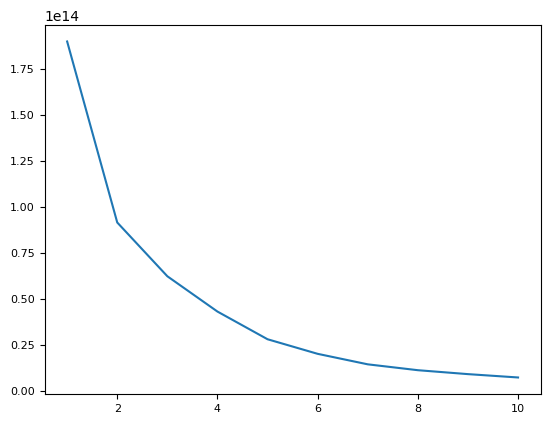

In [15]:
plt.rcParams.update({'font.size': 10})

inertia = []
for i in range(10):
    kmean = KMeans(n_clusters = i + 1, random_state = 0, n_init = 10)
    kmean.fit(Y_train.to_numpy().reshape(-1, 1))
    inertia.append(kmean.inertia_)
plt.plot([i + 1 for i in range(10)], inertia)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

In [16]:
kmean = KMeans(n_clusters = 2, random_state = 0, n_init = 10)
kmean.fit(Y_train.to_numpy().reshape(-1, 1))
X_label = kmean.predict(Y_train.to_numpy().reshape(-1, 1))
print(f"numbers of 1: {np.sum(X_label)}, numbers of 0: {X_label.shape[0] - np.sum(X_label)}")

numbers of 1: 6795, numbers of 0: 23201


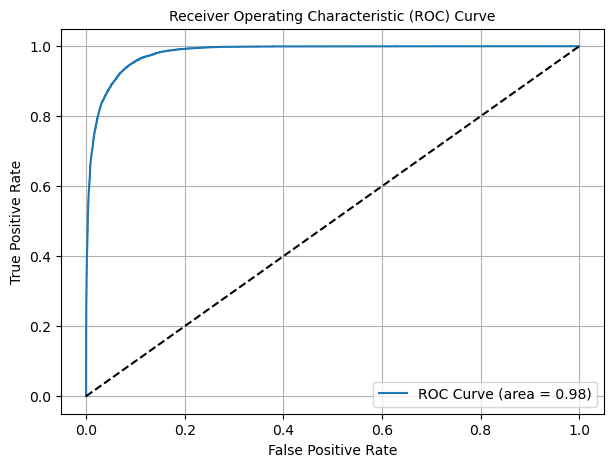

Precision: 0.8368, Recall: 0.8874, F1 score: 0.8614, Accuracy: 0.9353


In [17]:
classifier = lgb.LGBMClassifier(
                           boosting_type = 'gbdt', num_leaves = 10, 
                           max_depth = 6, learning_rate = 0.01, n_estimators = 3000, 
                           lambda_l1 = 3, lambda_l2 = 1, min_gain_to_split = 0.01,
                           bagging_freq = 10, scale_pos_weight = 1.5, feature_fraction = 0.6, verbose = -1
                          )
classifier.fit(X_train_standardize, X_label)
X_label_hat = classifier.predict(X_train_standardize) 
X_test_label_hat = classifier.predict(X_test_standardize) 
X_label_hat_prob = classifier.predict_proba(X_train_standardize)[:, 1]
classifier_performance(X_label, X_label_hat, X_label_hat_prob)

In [18]:
"""
eigens = np.linalg.eigvals(np.dot(X_train_standardize.T, X_train_standardize))
eigens.cumsum() / eigens.sum()
"""

'\neigens = np.linalg.eigvals(np.dot(X_train_standardize.T, X_train_standardize))\neigens.cumsum() / eigens.sum()\n'

In [19]:
"""
pca = PCA(n_components = 15)
pca.fit(X_train_standardize)
X_train_standardize = pca.transform(X_train_standardize)
X_test_standardize = pca.transform(X_test_standardize)

X_train_standardize = pd.DataFrame(X_train_standardize)
X_test_standardize = pd.DataFrame(X_test_standardize)
"""

'\npca = PCA(n_components = 15)\npca.fit(X_train_standardize)\nX_train_standardize = pca.transform(X_train_standardize)\nX_test_standardize = pca.transform(X_test_standardize)\n\nX_train_standardize = pd.DataFrame(X_train_standardize)\nX_test_standardize = pd.DataFrame(X_test_standardize)\n'

In [20]:
X_train_standardize = district_preprocessing(X_train_standardize, district_price_dict(X_train, Y_train))
X_test_standardize = district_preprocessing(X_test_standardize, district_price_dict(X_train, Y_train))

X_train_standardize = parkingtype_preprocessing(X_train_standardize, parkingtype_dict(X_train, Y_train))
X_test_standardize = parkingtype_preprocessing(X_test_standardize, parkingtype_dict(X_train, Y_train))

In [21]:
district = X_train_standardize.columns[X_train_standardize.columns.str.contains('District')]
X_train_standardize = X_train_standardize.drop(columns = district)
X_test_standardize = X_test_standardize.drop(columns = district)

parking = X_train_standardize.columns[X_train_standardize.columns.str.contains('Parking Type')]
X_train_standardize = X_train_standardize.drop(columns = parking)
X_test_standardize = X_test_standardize.drop(columns = parking)

In [22]:
lightgbm_model1 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 3000, verbose = -1)
lightgbm_model0 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 3000, verbose = -1)

train_1_index = np.where(X_label_hat == 1)[0]
train_0_index = np.where(X_label_hat == 0)[0]

test_1_index = np.where(X_test_label_hat == 1)[0]
test_0_index = np.where(X_test_label_hat == 0)[0]

lightgbm_model1.fit(X_train_standardize.iloc[train_1_index], Y_train.iloc[train_1_index])
lightgbm_model0.fit(X_train_standardize.iloc[train_0_index], Y_train.iloc[train_0_index])

Y_train_hat_gbm1 = lightgbm_model1.predict(X_train_standardize.iloc[train_1_index])
Y_train_hat_gbm0 = lightgbm_model0.predict(X_train_standardize.iloc[train_0_index])

train_index = np.concatenate([train_0_index, train_1_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm0, Y_train_hat_gbm1], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd = pd.DataFrame(train_dict)
train_pd = train_pd.sort_values(by = 'index')
train_pd.set_index('index', drop = True, inplace = True)
#display(train_pd)


Y_test_hat_gbm1 = lightgbm_model1.predict(X_test_standardize.iloc[test_1_index])
Y_test_hat_gbm0 = lightgbm_model0.predict(X_test_standardize.iloc[test_0_index])

test_index = np.concatenate([test_0_index, test_1_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm0, Y_test_hat_gbm1], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
#display(test_pd)
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_2stageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

# 2024/03/24 parking type沒有 target encoded最佳

Light GBM Regression: 11322.695


In [24]:
print(Y_train_hat_gbm0.mean(), Y_train_hat_gbm1.mean())
print(Y_train_hat_gbm0.shape[0], Y_train_hat_gbm1.shape[0])

print(f"Group 0 MAE: {mean_absolute_error(Y_train_hat_gbm0, Y_train.iloc[train_0_index])}")
print(f"Group 1 MAE: {mean_absolute_error(Y_train_hat_gbm1, Y_train.iloc[train_1_index])}")

print("=========================================")
print(Y_test_hat_gbm0.mean(), Y_test_hat_gbm1.mean())
print(Y_test_hat_gbm0.shape[0], Y_test_hat_gbm1.shape[0])

109367.40337873211 234344.13058456438
22790 7206
Group 0 MAE: 9356.222200084374
Group 1 MAE: 17541.94524898488
110265.17177256754 233861.4357089128
13589 4411


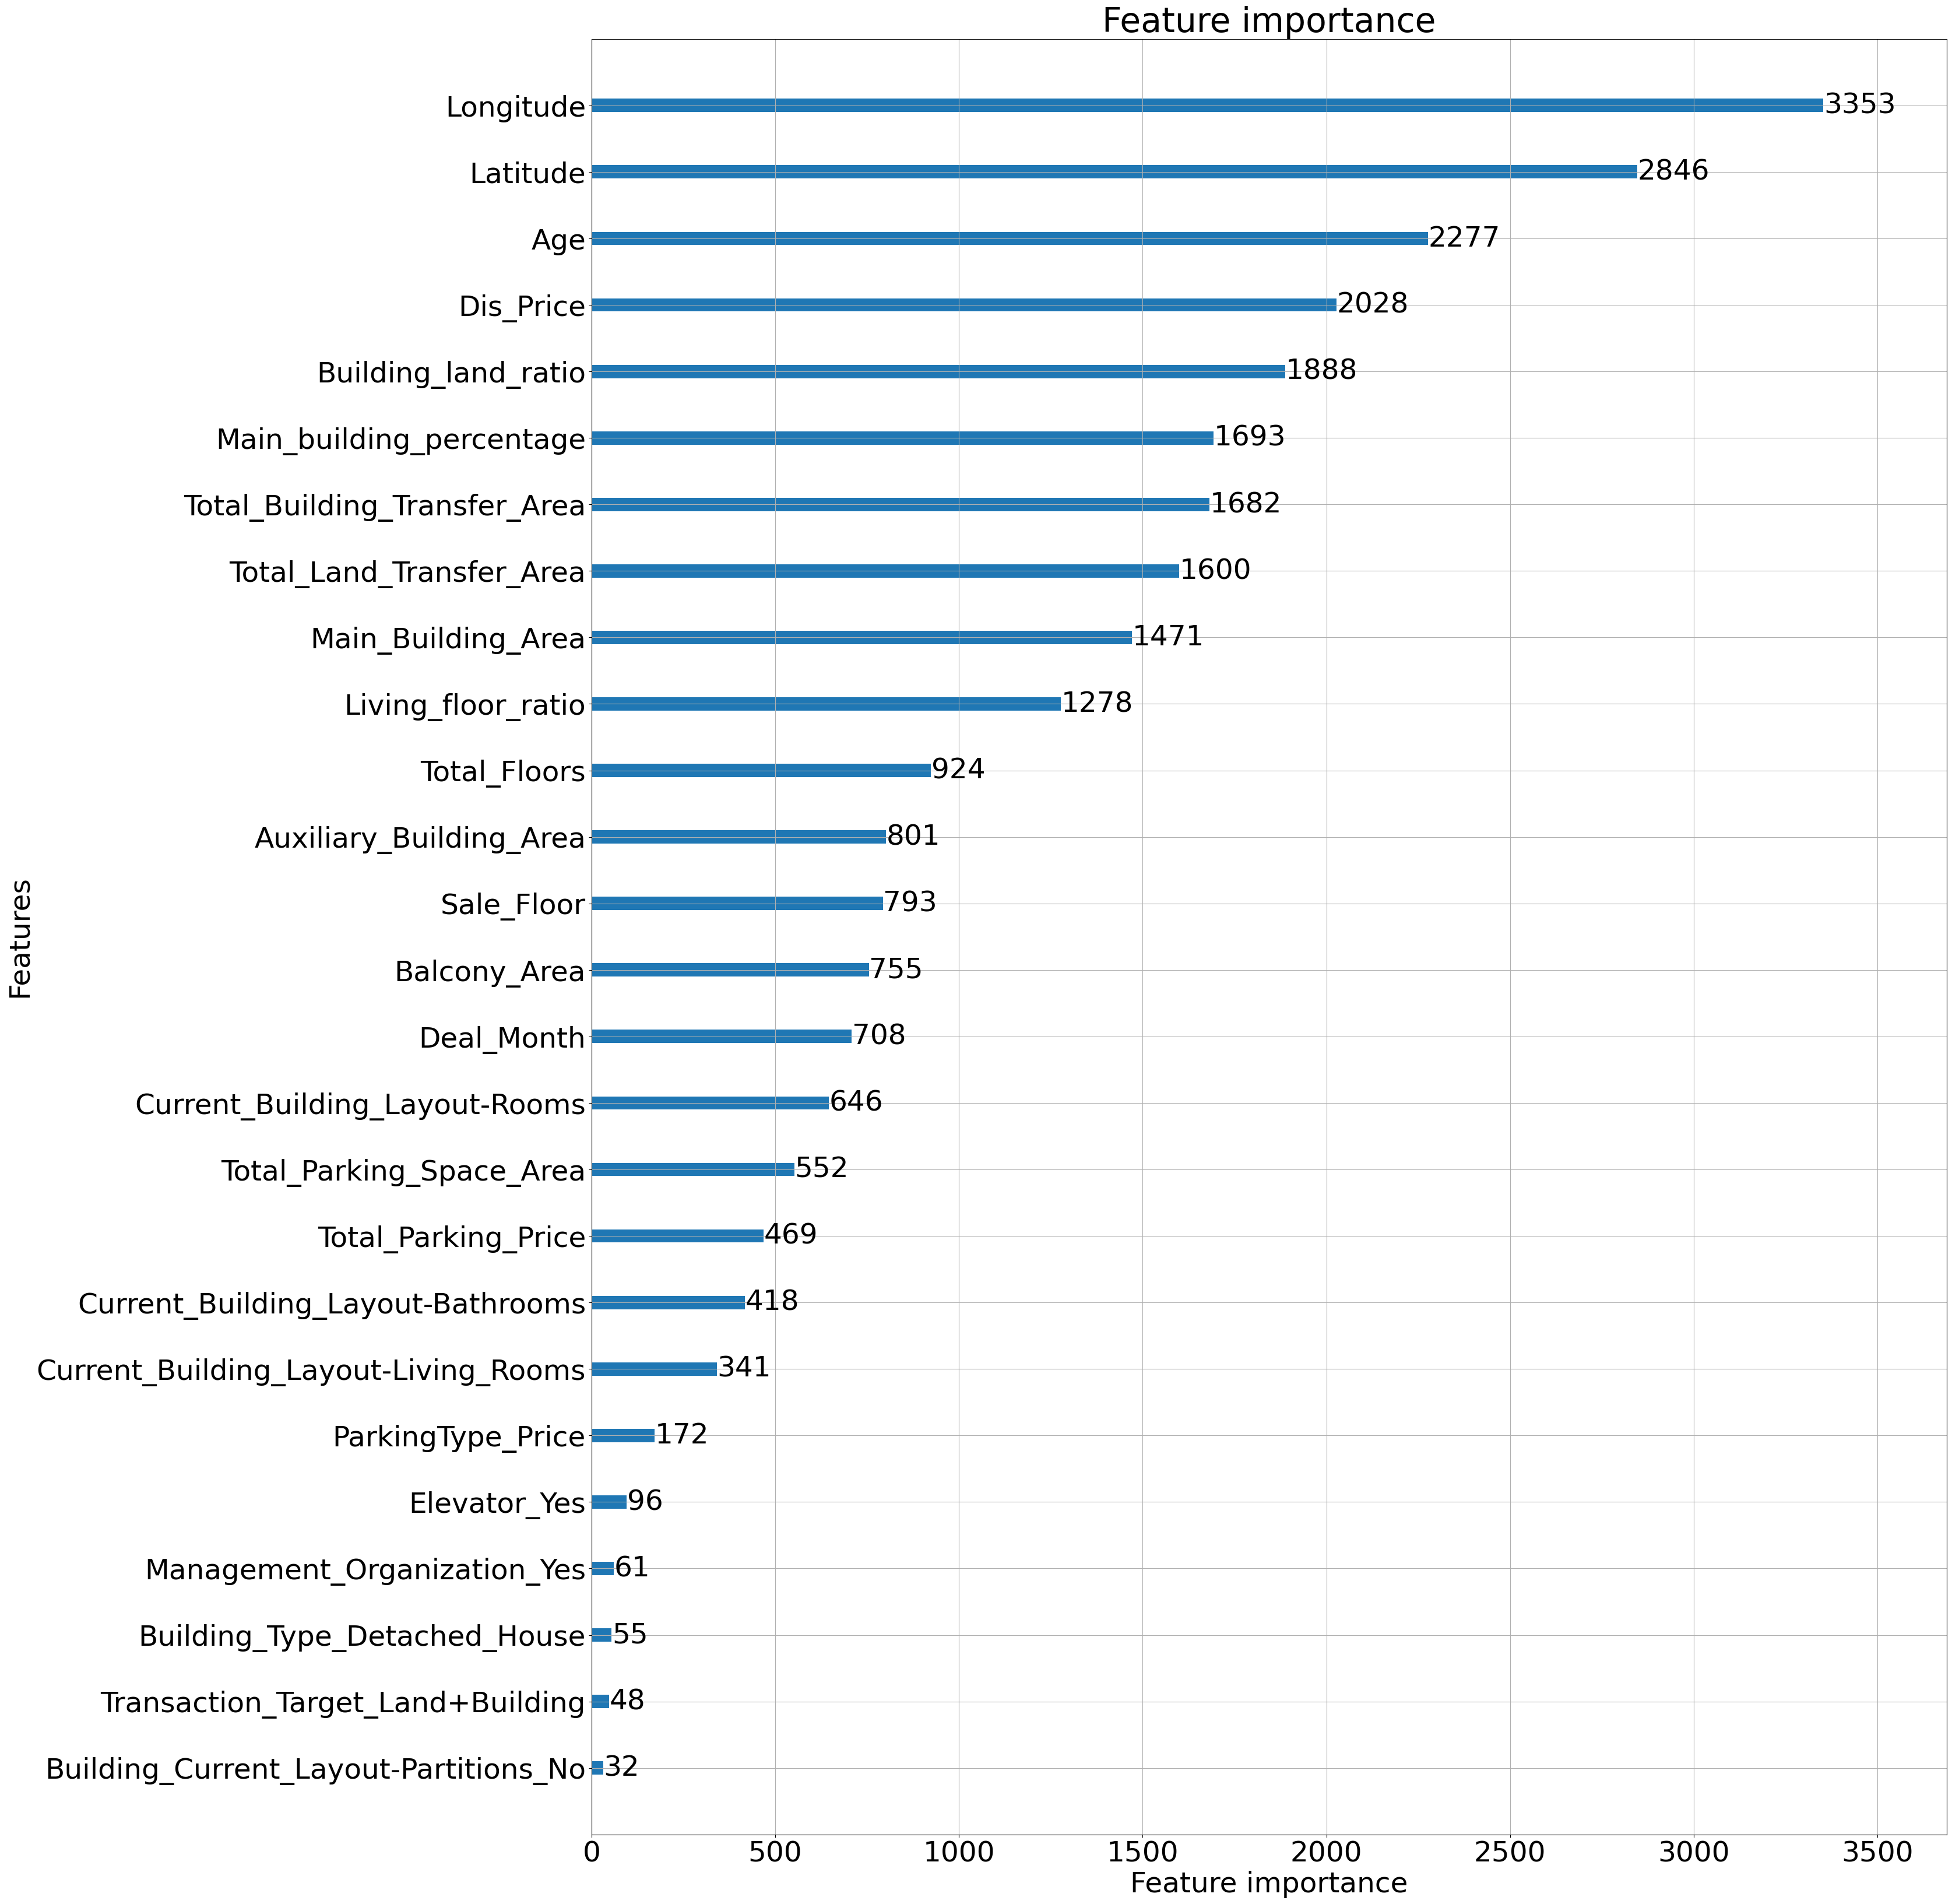

In [25]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model0)
fig = ax.figure
fig.set_size_inches(30, 40)

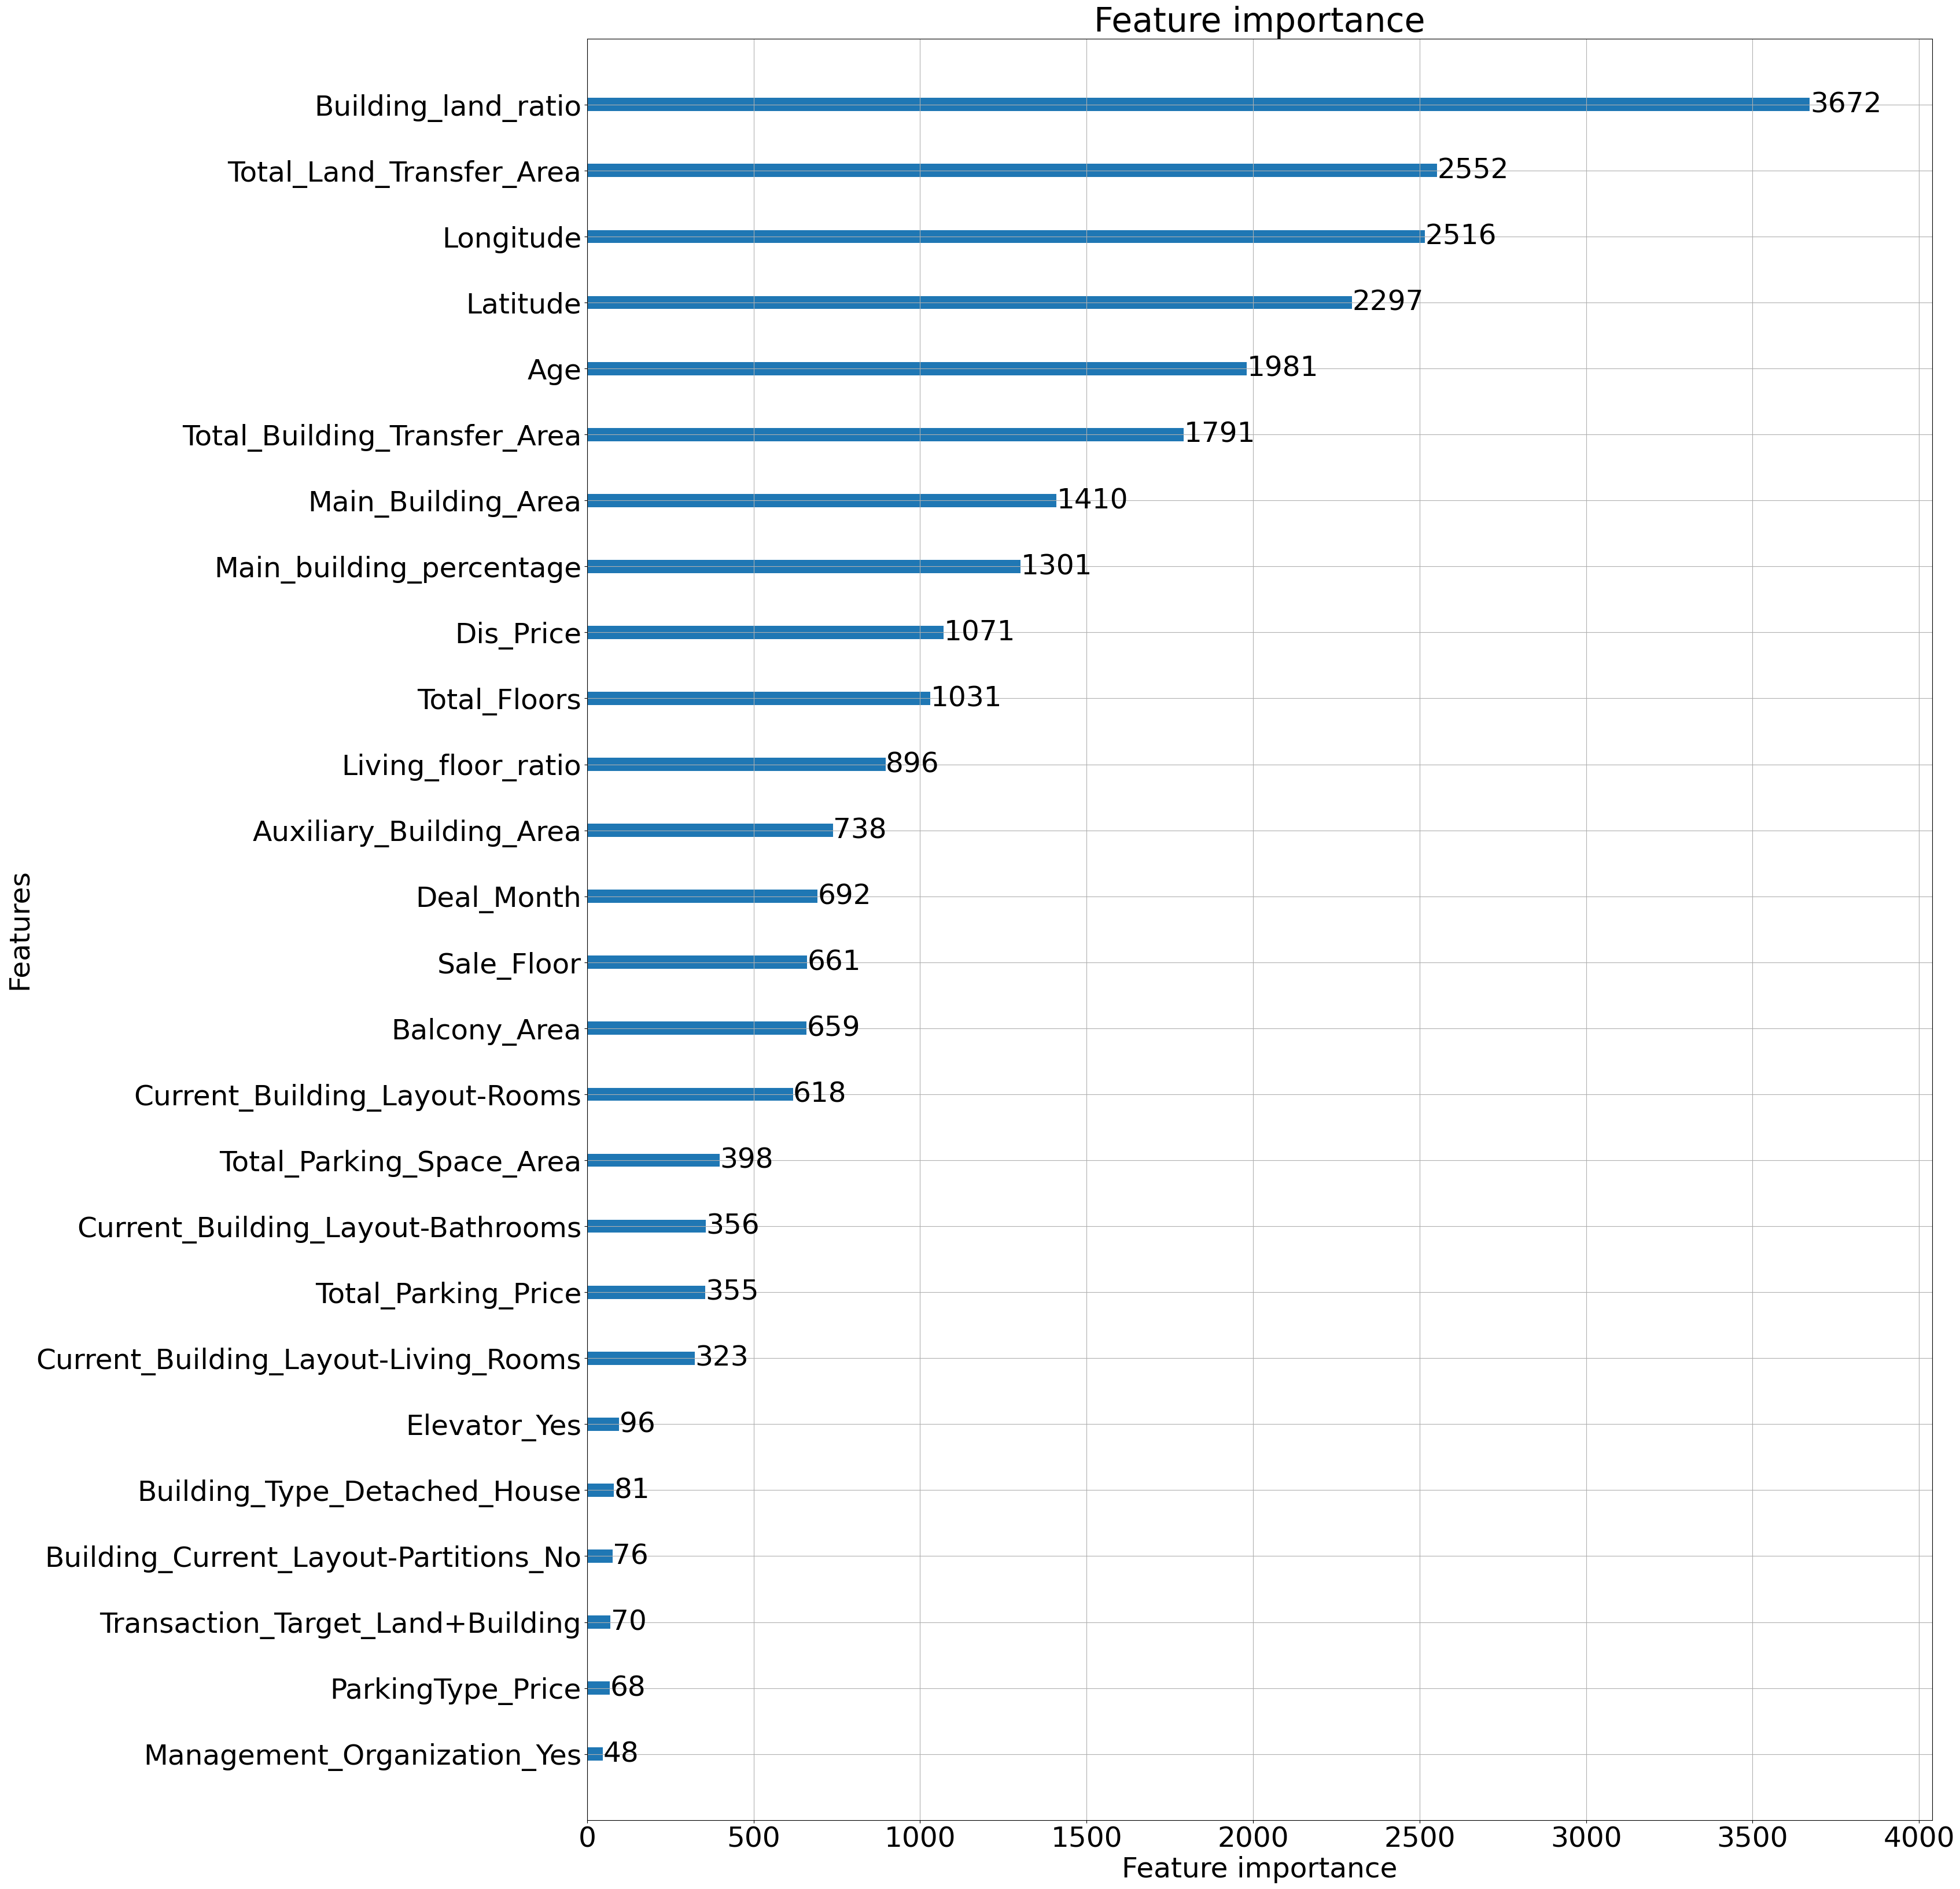

In [26]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model1)
fig = ax.figure
fig.set_size_inches(30, 40)

In [27]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        #print(f"MAE for {i}: {round(MAE_gbm_i, 3)}")
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
1,District_Sanzhi,4685.919844,147
9,District_Bali,4792.505677,356
36,District_Shuangxi,5763.152388,5
27,District_Tamsui,5866.496516,2322
32,District_Wanli,6209.280290,84
6,District_Wugu,6223.731691,650
22,District_Linkou,6305.097872,1104
37,District_Yingge,6448.050307,437
35,District_Jinshan,7214.535129,56
0,District_Sanxia,7222.714413,473


In [28]:
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_0_index][i]
        print(f"{i}: {data.sum()}")
        
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 469
District_Sanzhi: 147
District_Sanchong: 1395
District_Zhonghe: 1945
District_Zhongshan: 256
District_Zhongzheng: 46
District_Wugu: 650
District_Xinyi: 96
District_Neihu: 582
District_Bali: 356
District_Beitou: 602
District_Nangang: 178
District_Tucheng: 1023
District_Pinglin: 1
District_Shilin: 437
District_Datong: 213
District_Da'an: 11
District_Wenshan: 770
District_Xindian: 1382
District_Xinzhuang: 2117
District_Songshan: 13
District_Banqiao: 1647
District_Linkou: 1100
District_Shulin: 581
District_Yonghe: 651
District_Xizhi: 1725
District_Taishan: 306
District_Tamsui: 2320
District_Shenkeng: 115
District_Ruifang: 73
District_Shiding: 0
District_Shimen: 3
District_Wanhua: 439
District_Wanli: 84
District_Luzhou: 555
District_Gongliao: 5
District_Jinshan: 55
District_Shuangxi: 5
District_Yingge: 437


In [29]:
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_1_index][i]
        print(f"{i}: {data.sum()}")
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 4
District_Sanzhi: 0
District_Sanchong: 30
District_Zhonghe: 91
District_Zhongshan: 1284
District_Zhongzheng: 543
District_Wugu: 0
District_Xinyi: 718
District_Neihu: 729
District_Bali: 0
District_Beitou: 199
District_Nangang: 297
District_Tucheng: 6
District_Pinglin: 0
District_Shilin: 351
District_Datong: 218
District_Da'an: 1033
District_Wenshan: 209
District_Xindian: 195
District_Xinzhuang: 20
District_Songshan: 638
District_Banqiao: 249
District_Linkou: 4
District_Shulin: 11
District_Yonghe: 169
District_Xizhi: 4
District_Taishan: 0
District_Tamsui: 2
District_Shenkeng: 2
District_Ruifang: 0
District_Shiding: 0
District_Shimen: 1
District_Wanhua: 198
District_Wanli: 0
District_Luzhou: 0
District_Gongliao: 0
District_Jinshan: 1
District_Shuangxi: 0
District_Yingge: 0


In [30]:
for i in X_test.columns:
    if 'District' in i:
        data = X_test.iloc[test_0_index][i]
        print(f"{i}: {data.sum()}")
        
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 275
District_Sanzhi: 105
District_Sanchong: 819
District_Zhonghe: 1104
District_Zhongshan: 143
District_Zhongzheng: 25
District_Wugu: 399
District_Xinyi: 37
District_Neihu: 362
District_Bali: 196
District_Beitou: 375
District_Nangang: 117
District_Tucheng: 598
District_Pinglin: 0
District_Shilin: 269
District_Datong: 139
District_Da'an: 4
District_Wenshan: 460
District_Xindian: 759
District_Xinzhuang: 1267
District_Songshan: 6
District_Banqiao: 981
District_Linkou: 641
District_Shulin: 363
District_Yonghe: 390
District_Xizhi: 1027
District_Taishan: 205
District_Tamsui: 1453
District_Shenkeng: 74
District_Ruifang: 54
District_Shiding: 2
District_Shimen: 1
District_Wanhua: 264
District_Wanli: 44
District_Luzhou: 334
District_Gongliao: 6
District_Jinshan: 47
District_Shuangxi: 3
District_Yingge: 241


In [31]:
for i in X_test.columns:
    if 'District' in i:
        data = X_test.iloc[test_1_index][i]
        print(f"{i}: {data.sum()}")
        
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 0
District_Sanzhi: 0
District_Sanchong: 20
District_Zhonghe: 52
District_Zhongshan: 786
District_Zhongzheng: 314
District_Wugu: 3
District_Xinyi: 466
District_Neihu: 453
District_Bali: 0
District_Beitou: 118
District_Nangang: 165
District_Tucheng: 10
District_Pinglin: 0
District_Shilin: 237
District_Datong: 145
District_Da'an: 592
District_Wenshan: 137
District_Xindian: 103
District_Xinzhuang: 8
District_Songshan: 393
District_Banqiao: 157
District_Linkou: 1
District_Shulin: 6
District_Yonghe: 124
District_Xizhi: 2
District_Taishan: 0
District_Tamsui: 2
District_Shenkeng: 1
District_Ruifang: 0
District_Shiding: 0
District_Shimen: 0
District_Wanhua: 111
District_Wanli: 0
District_Luzhou: 3
District_Gongliao: 0
District_Jinshan: 2
District_Shuangxi: 0
District_Yingge: 0


## Taipei and New Taipei clusters

In [32]:
lightgbm_model_taipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 3000, verbose = -1)
lightgbm_model_newtaipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 3000, verbose = -1)

lightgbm_model_taipei.fit(X_train_standardize.iloc[train_taipei_index], Y_train.iloc[train_taipei_index])
lightgbm_model_newtaipei.fit(X_train_standardize.iloc[train_newtaipei_index], Y_train.iloc[train_newtaipei_index])

Y_train_hat_gbm_taipei = lightgbm_model_taipei.predict(X_train_standardize.iloc[train_taipei_index])
Y_train_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_train_standardize.iloc[train_newtaipei_index])

train_index = np.concatenate([train_newtaipei_index, train_taipei_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm_newtaipei, Y_train_hat_gbm_taipei], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd_knowledge = pd.DataFrame(train_dict)
train_pd_knowledge = train_pd_knowledge.sort_values(by = 'index')
train_pd_knowledge.set_index('index', drop = True, inplace = True)
#display(train_pd)


Y_test_hat_gbm_taipei = lightgbm_model_taipei.predict(X_test_standardize.iloc[test_taipei_index])
Y_test_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_test_standardize.iloc[test_newtaipei_index])

test_index = np.concatenate([test_newtaipei_index, test_taipei_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm_newtaipei, Y_test_hat_gbm_taipei], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
#display(test_pd)
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_Knowledge2StageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd_knowledge['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

# 2024/03/24 parking type沒有 target encoded最佳

Light GBM Regression: 11286.022


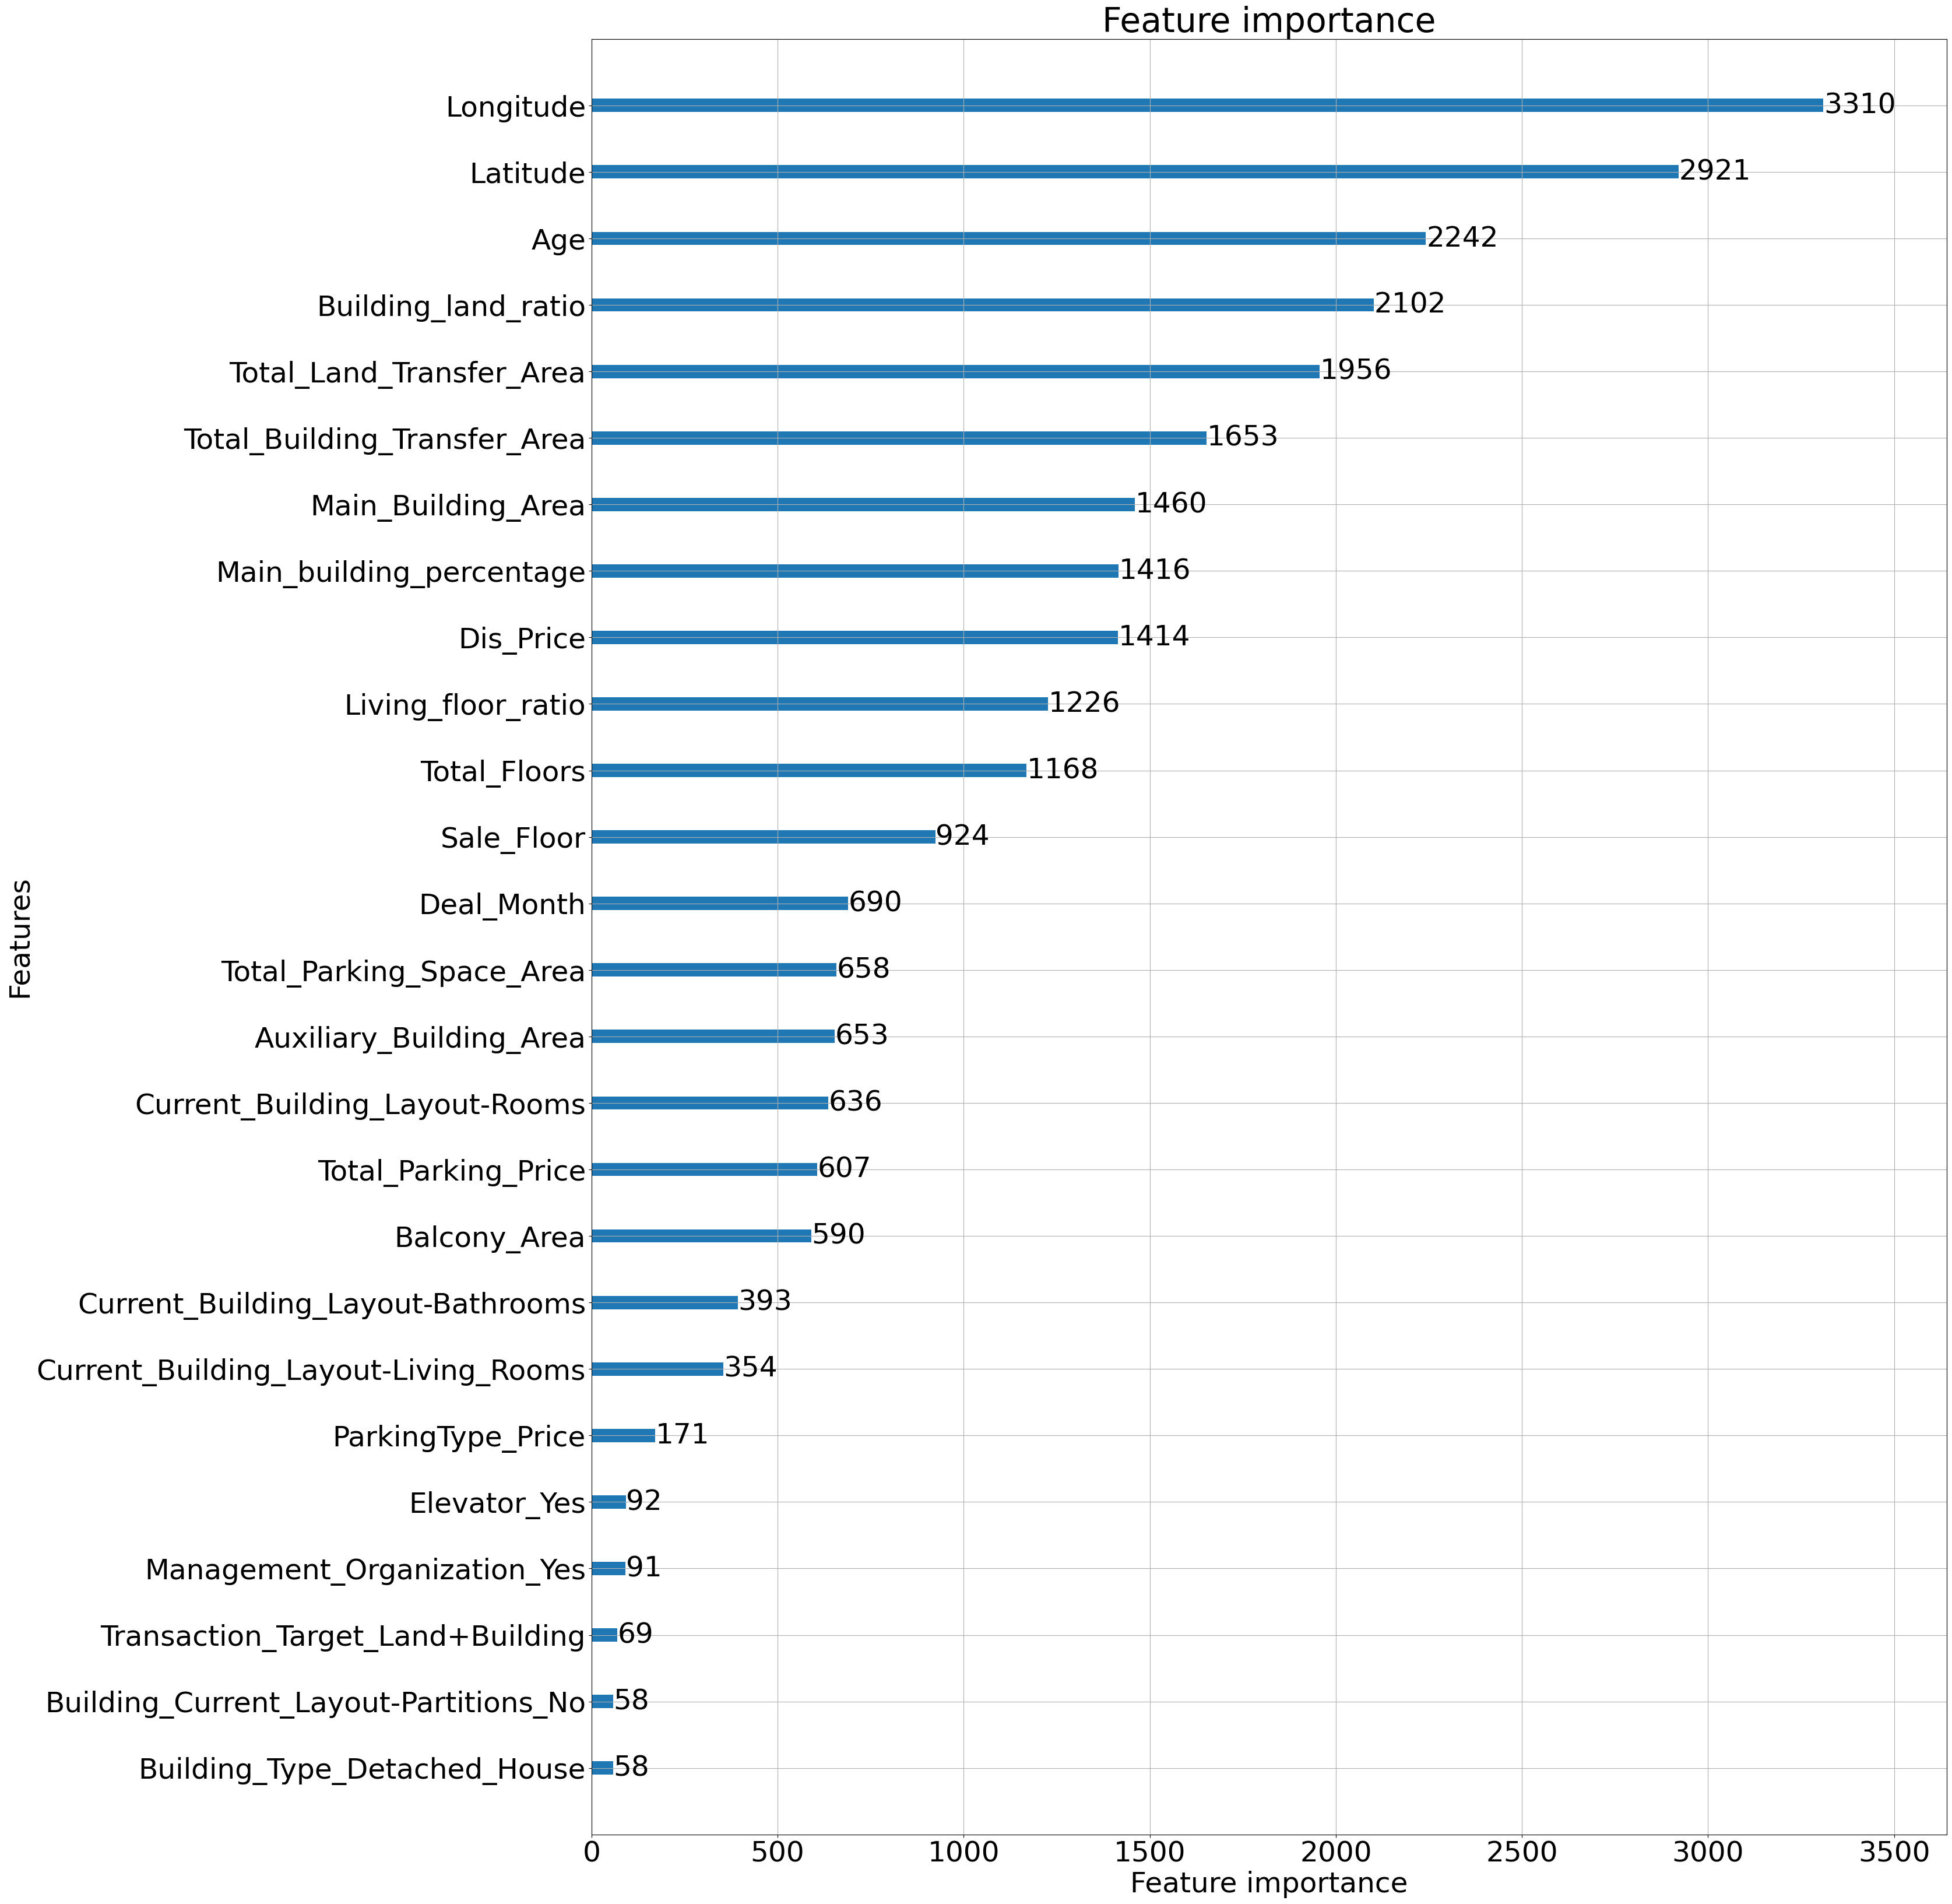

In [42]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model_newtaipei)
fig = ax.figure
fig.set_size_inches(30, 40)

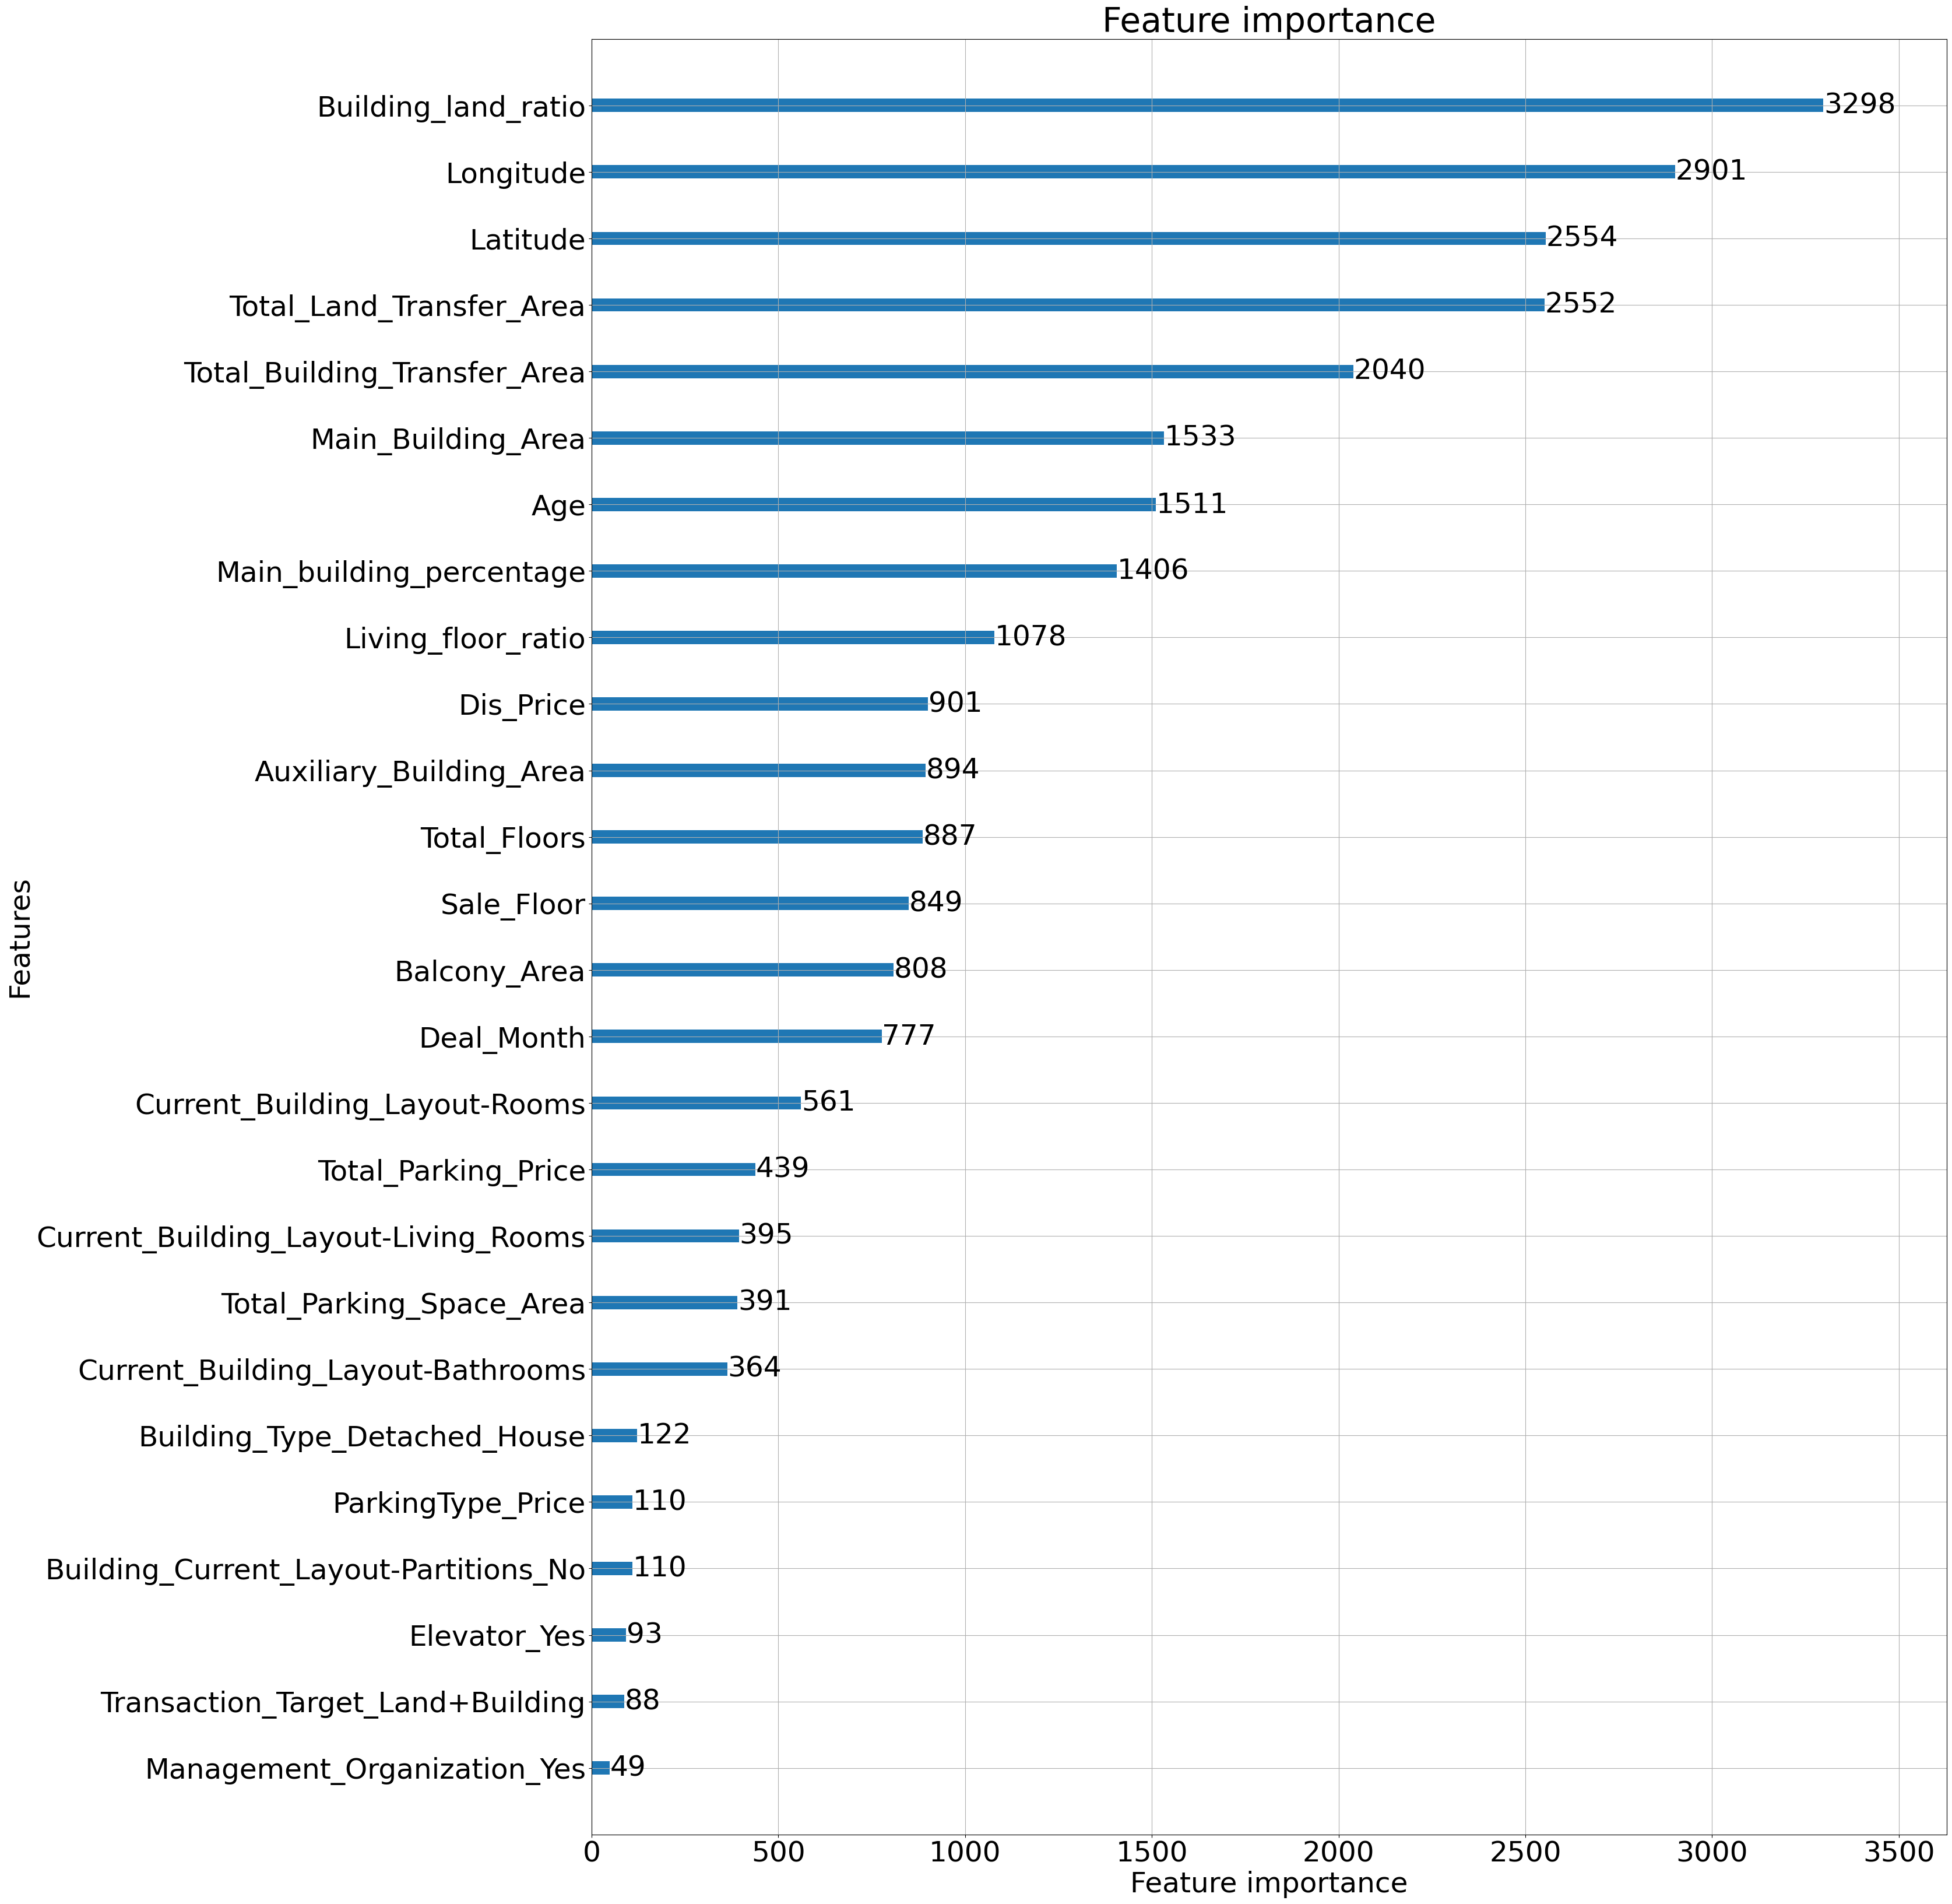

In [43]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model_taipei)
fig = ax.figure
fig.set_size_inches(30, 40)

In [44]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd_knowledge['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        #print(f"MAE for {i}: {round(MAE_gbm_i, 3)}")
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
1,District_Sanzhi,4435.906206,147
9,District_Bali,4483.545932,356
32,District_Wanli,4992.955778,84
27,District_Tamsui,5585.531390,2322
36,District_Shuangxi,5588.415809,5
6,District_Wugu,5894.771580,650
37,District_Yingge,5979.959812,437
22,District_Linkou,6027.750923,1104
30,District_Shimen,6078.156816,4
35,District_Jinshan,6273.295180,56


In [33]:
MAE_gbm = mean_absolute_error(Y_train, (train_pd['predict'] + train_pd_knowledge['predict'])/ 2)
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

Light GBM Regression: 10965.516


In [40]:
test_pd = pd.read_csv("test_2stageGBM_SunMar24.csv")
test_pd_knowledge = pd.read_csv("test_Knowledge2StageGBM_SunMar24.csv")
test_pd['Price'] = 0.5*(test_pd['Price'] + test_pd_knowledge['Price'])
test_pd.to_csv(f"test_Mix2StageGBM_{date}.csv", index = False)

In [46]:
X_train[X_train['District_Da\'an'] == 1]

,Total Land Transfer Area,Total Building Transfer Area,Current Building Layout-Rooms,Current Building Layout-Living Rooms,Current Building Layout-Bathrooms,Total Parking Space Area,Total Parking Price,Main Building Area,Auxiliary Building Area,Balcony Area,Latitude,Longitude,Deal Month,Total Floors,Sale Floor,District_Sanxia,District_Sanzhi,District_Sanchong,District_Zhonghe,District_Zhongshan,District_Zhongzheng,District_Wugu,District_Xinyi,District_Neihu,District_Bali,District_Beitou,District_Nangang,District_Tucheng,District_Pinglin,District_Shilin,District_Datong,District_Da'an,District_Wenshan,District_Xindian,District_Xinzhuang,District_Songshan,District_Banqiao,District_Linkou,District_Shulin,District_Yonghe,District_Xizhi,District_Taishan,District_Tamsui,District_Shenkeng,District_Ruifang,District_Shiding,District_Shimen,District_Wanhua,District_Wanli,District_Luzhou,District_Gongliao,District_Jinshan,District_Shuangxi,District_Yingge,Transaction Target Land+Building,Building Type Other,Building Type Storefront,Building Type Factory/Office,Building Type Farmhouse,Building Type Detached House,Building Current Layout-Partitions No,Management Organization Yes,Parking Type Flat on Ground Level,Parking Type Other,Parking Type Lift Plane,Parking Type Lift Mechanical,Parking Type Ramp Plane,Parking Type Ramp Mechanical,Parking Type Tower,Elevator Yes,Main building percentage,Building land ratio,Living floor ratio,Age
25,34.71,176.61,4,2,4,0.0,0,149.27,0.00,27.34,25.029733,121.543039,5,4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.845196,5.088159,1.000000,58
75,57.00,163.66,9,1,2,0.0,0,141.17,0.00,22.49,25.019084,121.533097,10,4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.862581,2.871228,1.000000,50
84,36.50,113.94,4,2,2,0.0,0,113.94,0.00,0.00,25.024906,121.546319,5,4,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,3.121644,0.500000,22
109,5.71,47.81,1,1,1,0.0,0,45.06,0.00,0.00,25.037092,121.549529,4,15,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.942481,8.373030,0.400000,48
155,46.00,182.26,3,2,3,0.0,0,182.26,0.00,0.00,25.027656,121.531585,9,6,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,3.962174,0.166667,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29949,32.95,116.56,6,2,5,0.0,0,95.60,10.81,0.00,25.026419,121.523691,6,5,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.820178,3.537481,1.000000,40
29953,21.57,80.16,3,2,1,0.0,0,68.11,12.05,0.00,25.032433,121.553527,8,5,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.849676,3.716273,1.000000,22
29966,12.85,75.42,1,1,1,0.0,0,43.84,0.00,3.90,25.017345,121.559856,1,13,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.581278,5.869261,0.384615,1
29981,24.74,118.61,3,2,2,0.0,0,93.19,0.00,5.61,25.023493,121.551277,1,7,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.785684,4.794260,0.857143,22
